# Import data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# fetch dataset and convert to pandas dataframe
wine_quality = fetch_ucirepo(id=186)
df = pd.concat([wine_quality.data.features, wine_quality.data.targets], axis=1)

# add the 'color' column from original dataset which is not included in features
df['color'] = wine_quality.data.original['color']

# redefine df to only include red wines
df = df[df['color'] == 'red']

# drop color as it is no longer needed
df = df.drop('color', axis=1)

# define X and y for modeling later
X = df.drop('quality', axis=1)
y = df['quality']

print(df.head())

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

# Create plot 1: histogram

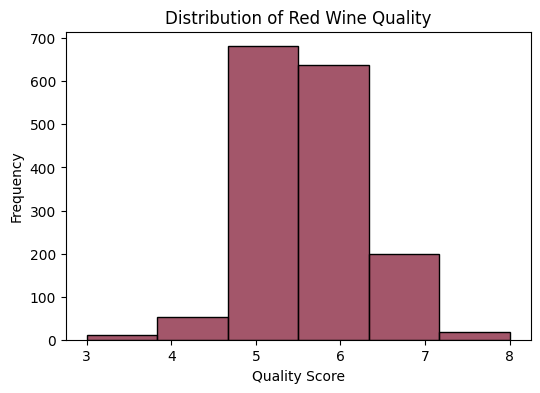

In [2]:
# histogram
plt.figure(figsize=(6, 4))
sns.histplot(df['quality'], bins=6, color='#851E38')
plt.title('Distribution of Red Wine Quality')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.show()

# Create plot 2: Heatmap

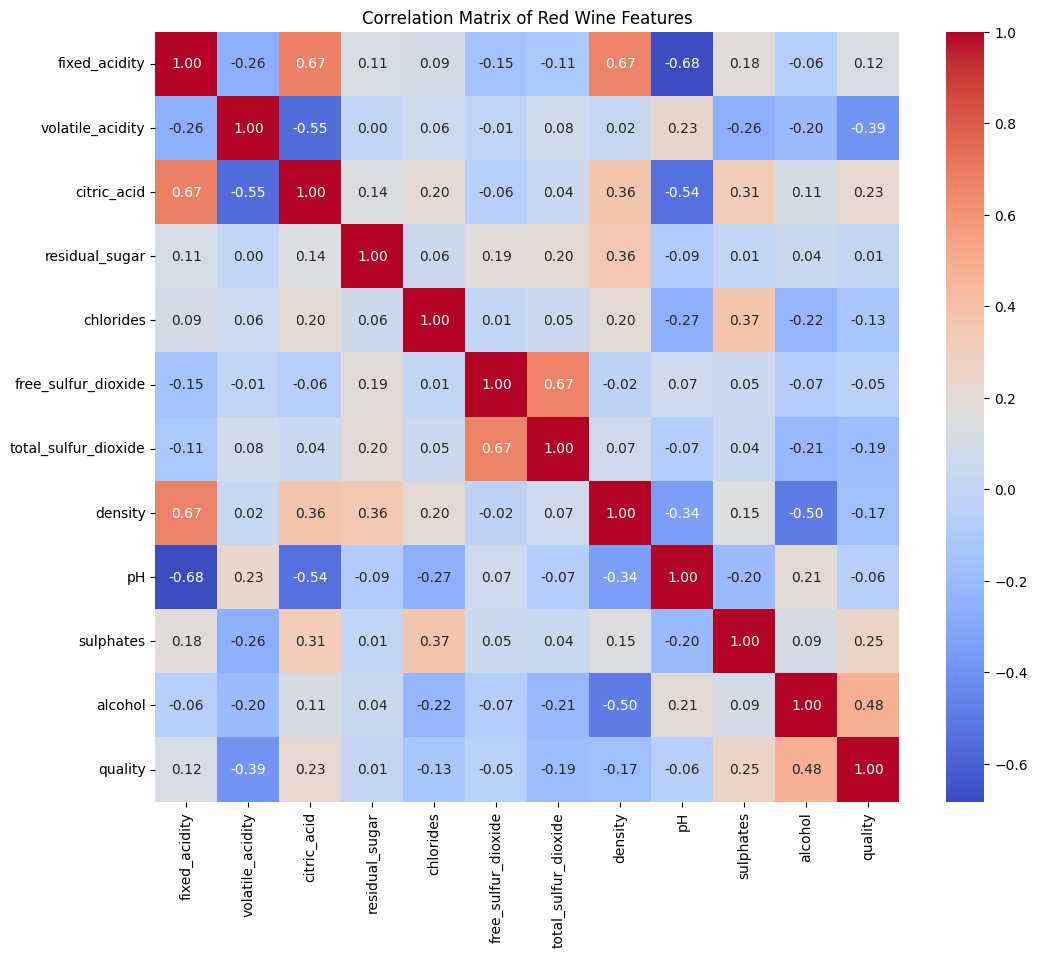

In [3]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Red Wine Features')
plt.show()

# Plot 3: scatterplots?

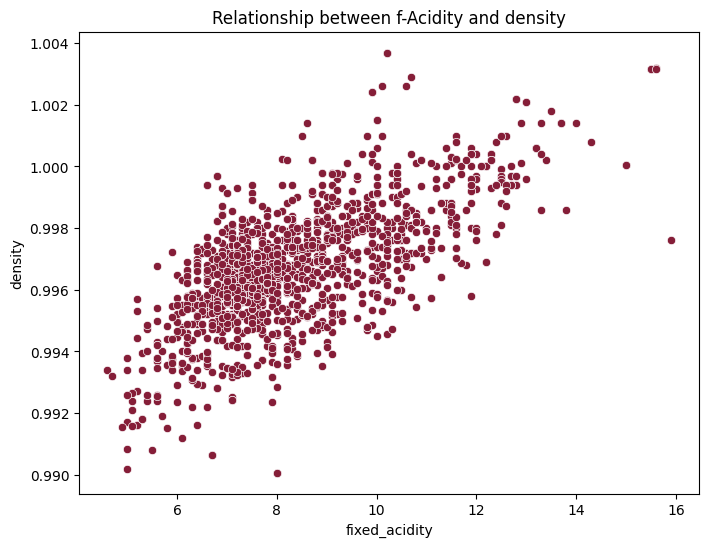

In [4]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='fixed_acidity', y='density', data=df, color='#851E38')
plt.title('Relationship between f-Acidity and density')
plt.xlabel('fixed_acidity')
plt.ylabel('density')
plt.show()

# box plots

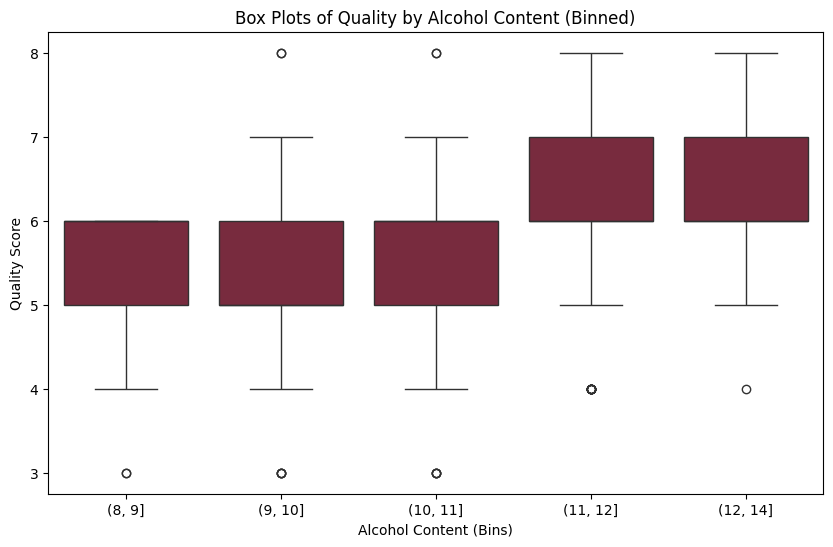

In [5]:
bin_edges = [8, 9, 10, 11, 12, 14]

df['alcohol_bin'] = pd.cut(df['alcohol'], bins=bin_edges)

plt.figure(figsize=(10, 6))
sns.boxplot(x='alcohol_bin', y='quality', data=df, color='#851E38')
plt.title('Box Plots of Quality by Alcohol Content (Binned)')
plt.xlabel('Alcohol Content (Bins)')
plt.ylabel('Quality Score')
plt.show()

# pair plots

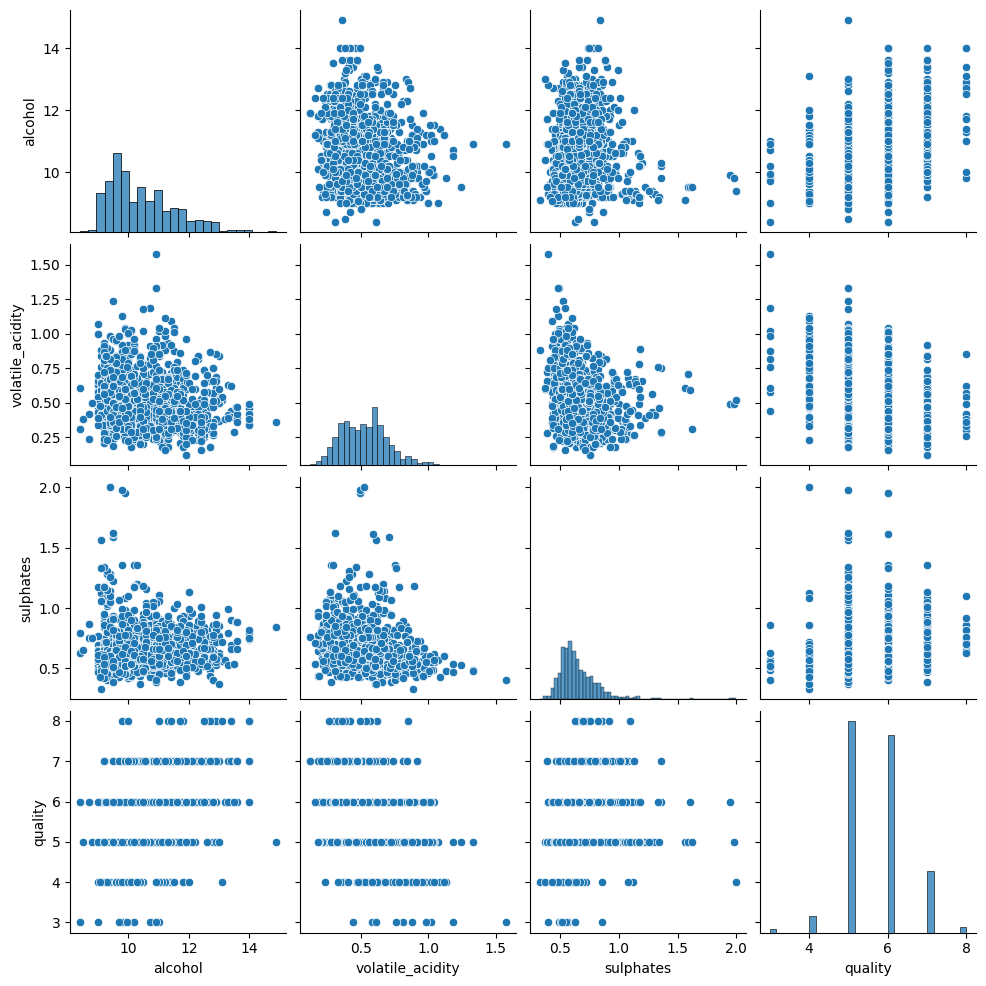

In [6]:
sns.pairplot(df, vars=['alcohol', 'volatile_acidity', 'sulphates', 'quality'])
plt.show()

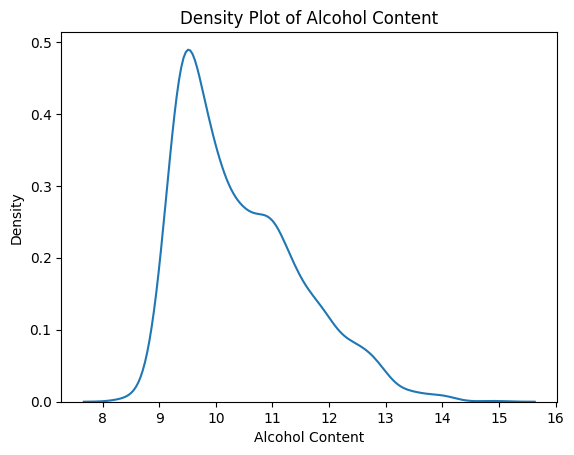

In [7]:
sns.kdeplot(df['alcohol'])
plt.title('Density Plot of Alcohol Content')
plt.xlabel('Alcohol Content')
plt.ylabel('Density')
plt.show()

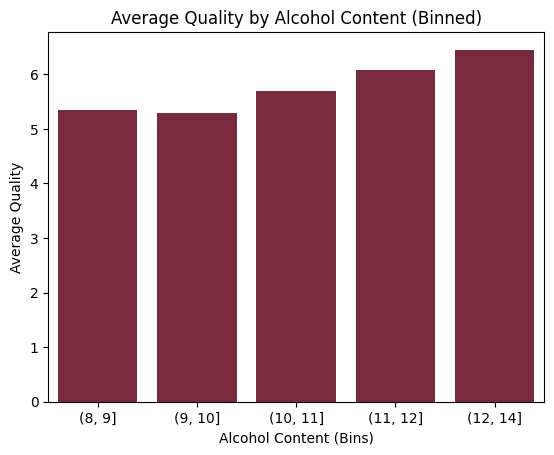

In [8]:
average_quality_by_bin = df.groupby('alcohol_bin', observed=True)['quality'].mean().reset_index()
sns.barplot(x='alcohol_bin', y='quality', data=average_quality_by_bin, color='#851E38')
plt.title('Average Quality by Alcohol Content (Binned)')
plt.xlabel('Alcohol Content (Bins)')
plt.ylabel('Average Quality')
plt.show()

# Create Model

In [9]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize scaler
scaler = StandardScaler()

# fit and transform training feature data
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)   # convert back to pandas df

y_train_scaled = y_train / 10

# train model
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [10]:
# transform test data
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)   # convert back to pandas df

y_test_scaled = y_test / 10

# test model on test data
y_pred = lin_model.predict(X_test_scaled)

# mean squared error
mse_scaled = mean_squared_error(y_test_scaled, y_pred)
mse = mse_scaled * (10**2)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.3900251439643171


In [11]:
def predict_wine_quality(user_input):
    user_input_df = pd.DataFrame([user_input], columns=X.columns)
    scaled_user_input = scaler.transform(user_input_df)  # reuse the 'scaler'
    scaled_user_input = pd.DataFrame(scaled_user_input, columns=X.columns)   # convert back to pandas df
    prediction = lin_model.predict(scaled_user_input)
    return prediction[0]

# feature_names = X.columns
wine_properties = {}

for feature in X.columns:
    while True:
        try:
            value = float(input(f'{feature}: '))
            wine_properties[feature] = value
            break  # Exit the loop if input is valid
        except ValueError:
            print("Invalid input. Please enter a number.")

# rescale and clip results to 0-10
predicted_quality = round(predict_wine_quality(list(wine_properties.values())),2) * 10
clipped_prediction = np.clip(predicted_quality, 0, 10)

print('\nYour wine\'s predicted quality score (0-10) is: ' + str(clipped_prediction))

fixed_acidity:  7.4
volatile_acidity:  .7
citric_acid:  0.1.9


Invalid input. Please enter a number.


citric_acid:  .076
residual_sugar:  11
chlorides:  34
free_sulfur_dioxide:  .9978
total_sulfur_dioxide:  3.51
density:  0.56
pH:  8
sulphates:  0.56
alcohol:  9.4



Your wine's predicted quality score (0-10) is: 0.0
